In [29]:
# CELL 1
# AutoGovern Z: Installation and Setup
!pip install plotly dash jupyter-dash scikit-learn pandas numpy seaborn matplotlib
!pip install scipy statsmodels lime shap xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
import hashlib
import datetime
import json
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed and imported successfully!")


✅ All packages installed and imported successfully!


In [30]:
# CELL 2
# AutoGovern Z: Data Loading Classes

class DataLoader:
    """Load and prepare datasets for AutoGovern Z demonstration"""

    def __init__(self):
        self.datasets = {}

    def load_german_credit_data(self):
        """Load German Credit Risk dataset"""
        from sklearn.datasets import fetch_openml

        # Load German Credit dataset
        german_credit = fetch_openml('german', version=1, as_frame=True)
        df = german_credit.frame

        # Prepare features
        df['target'] = (df['class'] == 'good').astype(int)
        df = df.drop('class', axis=1)

        # Create protected attribute (age groups)
        df['age_group'] = pd.cut(df['age'], bins=[0, 35, 65, 100], labels=['young', 'middle', 'senior'])
        df['is_young'] = (df['age_group'] == 'young').astype(int)

        self.datasets['german_credit'] = df
        return df

    def create_synthetic_loan_data(self, n_samples=10000):
        """Create synthetic loan approval dataset with intentional bias"""
        np.random.seed(42)

        # Generate synthetic features
        age = np.random.normal(45, 15, n_samples)
        income = np.random.lognormal(10.5, 0.5, n_samples)
        credit_score = np.random.normal(650, 100, n_samples)
        loan_amount = np.random.lognormal(11, 0.8, n_samples)

        # Protected attributes
        gender = np.random.choice(['M', 'F'], n_samples, p=[0.6, 0.4])
        race = np.random.choice(['White', 'Black', 'Hispanic', 'Asian', 'Other'],
                               n_samples, p=[0.6, 0.15, 0.15, 0.08, 0.02])

        # Create bias in loan approval (intentional for demonstration)
        base_prob = 0.7
        age_factor = np.where(age > 65, -0.2, 0.1)
        gender_factor = np.where(gender == 'F', -0.15, 0)  # Gender bias
        race_factor = np.where((race == 'Black') | (race == 'Hispanic'), -0.25, 0)  # Racial bias
        income_factor = (income - income.mean()) / income.std() * 0.3
        credit_factor = (credit_score - credit_score.mean()) / credit_score.std() * 0.4

        approval_prob = base_prob + age_factor + gender_factor + race_factor + income_factor + credit_factor
        approval_prob = np.clip(approval_prob, 0.1, 0.9)

        approved = np.random.binomial(1, approval_prob)

        df = pd.DataFrame({
            'age': age,
            'income': income,
            'credit_score': credit_score,
            'loan_amount': loan_amount,
            'gender': gender,
            'race': race,
            'approved': approved,
            'is_female': (gender == 'F').astype(int),
            'is_minority': ((race == 'Black') | (race == 'Hispanic')).astype(int)
        })

        self.datasets['synthetic_loans'] = df
        return df

# Test the data loader
data_loader = DataLoader()
sample_data = data_loader.create_synthetic_loan_data(5000)
print(f"✅ Created synthetic loan dataset: {sample_data.shape}")
print(f"📊 Approval rate: {sample_data['approved'].mean():.2%}")
print(f"👥 Gender distribution: {sample_data['gender'].value_counts().to_dict()}")
print(f"🌍 Race distribution: {sample_data['race'].value_counts().to_dict()}")


✅ Created synthetic loan dataset: (5000, 9)
📊 Approval rate: 57.26%
👥 Gender distribution: {'M': 3040, 'F': 1960}
🌍 Race distribution: {'White': 2976, 'Black': 803, 'Hispanic': 723, 'Asian': 390, 'Other': 108}


In [31]:
# CELL 3
# AutoGovern Z: Bias Detection and Fairness Assessment

class BiasDetector:
    """Advanced bias detection and fairness assessment"""

    def __init__(self):
        self.fairness_metrics = {}

    def demographic_parity(self, y_pred, protected_attr):
        """Calculate demographic parity difference"""
        df = pd.DataFrame({'pred': y_pred, 'protected': protected_attr})

        pos_rate_protected = df[df['protected'] == 1]['pred'].mean()
        pos_rate_unprotected = df[df['protected'] == 0]['pred'].mean()

        return abs(pos_rate_protected - pos_rate_unprotected)

    def equal_opportunity(self, y_true, y_pred, protected_attr):
        """Calculate equal opportunity difference (TPR parity)"""
        df = pd.DataFrame({'true': y_true, 'pred': y_pred, 'protected': protected_attr})

        # True positive rates for each group
        tpr_protected = df[(df['protected'] == 1) & (df['true'] == 1)]['pred'].mean()
        tpr_unprotected = df[(df['protected'] == 0) & (df['true'] == 1)]['pred'].mean()

        if pd.isna(tpr_protected) or pd.isna(tpr_unprotected):
            return 0.0

        return abs(tpr_protected - tpr_unprotected)

    def equalized_odds(self, y_true, y_pred, protected_attr):
        """Calculate equalized odds difference"""
        df = pd.DataFrame({'true': y_true, 'pred': y_pred, 'protected': protected_attr})

        # TPR difference
        tpr_diff = self.equal_opportunity(y_true, y_pred, protected_attr)

        # FPR difference
        fpr_protected = df[(df['protected'] == 1) & (df['true'] == 0)]['pred'].mean()
        fpr_unprotected = df[(df['protected'] == 0) & (df['true'] == 0)]['pred'].mean()

        if pd.isna(fpr_protected) or pd.isna(fpr_unprotected):
            fpr_diff = 0.0
        else:
            fpr_diff = abs(fpr_protected - fpr_unprotected)

        return max(tpr_diff, fpr_diff)

    def comprehensive_bias_assessment(self, y_true, y_pred, protected_attrs):
        """Perform comprehensive bias assessment"""
        results = {}

        for attr_name, attr_values in protected_attrs.items():
            results[attr_name] = {
                'demographic_parity': self.demographic_parity(y_pred, attr_values),
                'equal_opportunity': self.equal_opportunity(y_true, y_pred, attr_values),
                'equalized_odds': self.equalized_odds(y_true, y_pred, attr_values)
            }

            # Overall fairness score (lower is better)
            results[attr_name]['fairness_score'] = np.mean([
                results[attr_name]['demographic_parity'],
                results[attr_name]['equal_opportunity'],
                results[attr_name]['equalized_odds']
            ])

        return results

    def visualize_bias_metrics(self, bias_results):
        """Create bias visualization"""
        fig, axes = plt.subplots(1, len(bias_results), figsize=(15, 5))
        if len(bias_results) == 1:
            axes = [axes]

        for idx, (attr, metrics) in enumerate(bias_results.items()):
            fairness_metrics = ['Demographic\nParity', 'Equal\nOpportunity', 'Equalized\nOdds']
            values = [metrics['demographic_parity'], metrics['equal_opportunity'], metrics['equalized_odds']]
            colors = ['red' if v > 0.1 else 'orange' if v > 0.05 else 'green' for v in values]

            axes[idx].bar(fairness_metrics, values, color=colors)
            axes[idx].set_title(f'Bias Assessment: {attr.title()}')
            axes[idx].set_ylabel('Bias Score (lower is better)')
            axes[idx].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Warning (0.05)')
            axes[idx].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Critical (0.1)')
            axes[idx].legend()
            axes[idx].set_ylim(0, max(0.2, max(values) * 1.1))

        plt.tight_layout()
        plt.show()

# Test bias detector
bias_detector = BiasDetector()
print("✅ Bias Detection Engine initialized successfully!")


✅ Bias Detection Engine initialized successfully!


In [32]:
# CELL 4
# AutoGovern Z: Model Drift Detection System

class DriftDetector:
    """Advanced model drift detection system"""

    def __init__(self):
        self.baseline_stats = {}

    def calculate_psi(self, baseline, current, bins=10):
        """Calculate Population Stability Index"""
        # Create bins based on baseline distribution
        bin_edges = np.percentile(baseline, np.linspace(0, 100, bins + 1))
        bin_edges[0] = -np.inf
        bin_edges[-1] = np.inf

        # Calculate distributions
        baseline_dist = np.histogram(baseline, bins=bin_edges)[0] / len(baseline)
        current_dist = np.histogram(current, bins=bin_edges)[0] / len(current)

        # Avoid division by zero
        baseline_dist = np.maximum(baseline_dist, 1e-6)
        current_dist = np.maximum(current_dist, 1e-6)

        # Calculate PSI
        psi = np.sum((current_dist - baseline_dist) * np.log(current_dist / baseline_dist))
        return psi

    def ks_test_drift(self, baseline, current):
        """Kolmogorov-Smirnov test for distribution drift"""
        statistic, p_value = ks_2samp(baseline, current)
        return {
            'ks_statistic': statistic,
            'p_value': p_value,
            'drift_detected': p_value < 0.05
        }

    def prediction_drift(self, baseline_preds, current_preds):
        """Detect drift in model predictions"""
        return {
            'psi': self.calculate_psi(baseline_preds, current_preds),
            'ks_test': self.ks_test_drift(baseline_preds, current_preds),
            'mean_shift': abs(np.mean(current_preds) - np.mean(baseline_preds)),
            'std_shift': abs(np.std(current_preds) - np.std(baseline_preds))
        }

    def feature_drift_analysis(self, baseline_data, current_data):
        """Comprehensive feature drift analysis"""
        drift_results = {}

        for column in baseline_data.columns:
            if baseline_data[column].dtype in ['int64', 'float64']:
                drift_results[column] = {
                    'psi': self.calculate_psi(baseline_data[column], current_data[column]),
                    'ks_test': self.ks_test_drift(baseline_data[column], current_data[column])
                }

        return drift_results

    def visualize_drift(self, baseline, current, feature_name):
        """Visualize drift between baseline and current data"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Distribution comparison
        ax1.hist(baseline, bins=50, alpha=0.7, label='Baseline', density=True)
        ax1.hist(current, bins=50, alpha=0.7, label='Current', density=True)
        ax1.set_title(f'{feature_name} Distribution Comparison')
        ax1.set_xlabel(feature_name)
        ax1.set_ylabel('Density')
        ax1.legend()

        # PSI and KS test results
        psi_score = self.calculate_psi(baseline, current)
        ks_result = self.ks_test_drift(baseline, current)

        metrics = ['PSI Score', 'KS Statistic']
        values = [psi_score, ks_result['ks_statistic']]
        colors = ['red' if psi_score > 0.2 else 'orange' if psi_score > 0.1 else 'green',
                 'red' if ks_result['p_value'] < 0.01 else 'orange' if ks_result['p_value'] < 0.05 else 'green']

        ax2.bar(metrics, values, color=colors)
        ax2.set_title(f'Drift Metrics: {feature_name}')
        ax2.set_ylabel('Score')

        # Add threshold lines
        ax2.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7)
        ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

        return {'psi': psi_score, 'ks_test': ks_result}

# Test drift detector
drift_detector = DriftDetector()
print("✅ Model Drift Detection System initialized successfully!")


✅ Model Drift Detection System initialized successfully!


In [33]:
# CELL 5
# AutoGovern Z: Regulatory Compliance Monitoring

class ComplianceMonitor:
    """Regulatory compliance monitoring system"""

    def __init__(self):
        self.compliance_scores = {}

    def basel_iii_assessment(self, model_metrics, bias_metrics):
        """Basel III operational risk assessment"""
        # Model performance criteria
        accuracy_score = min(model_metrics.get('accuracy', 0) * 100, 100)
        stability_score = max(0, 100 - model_metrics.get('drift_score', 0) * 10)

        # Bias criteria - convert to 0-100 scale (lower bias = higher score)
        if isinstance(bias_metrics, dict) and 'fairness_score' in bias_metrics:
            fairness_score = max(0, 100 - bias_metrics['fairness_score'] * 100)
        else:
            fairness_score = max(0, 100 - bias_metrics * 100)

        # Overall Basel III score
        basel_score = (accuracy_score * 0.4 + stability_score * 0.3 + fairness_score * 0.3)

        return {
            'overall_score': basel_score,
            'accuracy_component': accuracy_score,
            'stability_component': stability_score,
            'fairness_component': fairness_score,
            'status': 'compliant' if basel_score >= 85 else 'warning' if basel_score >= 70 else 'non_compliant'
        }

    def gdpr_assessment(self, model_metadata):
        """GDPR compliance assessment"""
        criteria = {
            'data_minimization': model_metadata.get('data_minimization', False),
            'purpose_limitation': model_metadata.get('purpose_limitation', False),
            'transparency': model_metadata.get('explainability_available', False),
            'accountability': model_metadata.get('audit_trail', False),
            'data_subject_rights': model_metadata.get('subject_rights_supported', False)
        }

        score = sum(criteria.values()) / len(criteria) * 100

        return {
            'overall_score': score,
            'criteria': criteria,
            'status': 'compliant' if score >= 80 else 'warning' if score >= 60 else 'non_compliant'
        }

    def eu_ai_act_assessment(self, model_risk_level, governance_measures):
        """EU AI Act compliance assessment"""
        if model_risk_level == 'high':
            required_measures = [
                'quality_management', 'data_governance', 'technical_documentation',
                'transparency', 'human_oversight', 'accuracy_robustness'
            ]
        else:
            required_measures = ['transparency', 'technical_documentation']

        implemented = sum([governance_measures.get(measure, False) for measure in required_measures])
        score = implemented / len(required_measures) * 100

        return {
            'overall_score': score,
            'risk_level': model_risk_level,
            'required_measures': len(required_measures),
            'implemented_measures': implemented,
            'status': 'compliant' if score >= 90 else 'warning' if score >= 70 else 'non_compliant'
        }

    def generate_compliance_dashboard(self, all_results):
        """Generate visual compliance dashboard for all models"""
        if not all_results:
            print("No compliance results available")
            return

        # Extract data correctly from the nested structure
        model_names = list(all_results.keys())

        # Extract compliance scores for each framework
        basel_scores = []
        gdpr_scores = []
        eu_scores = []

        for model_id in model_names:
            basel_scores.append(all_results[model_id]['basel_iii']['overall_score'])
            gdpr_scores.append(all_results[model_id]['gdpr']['overall_score'])
            eu_scores.append(all_results[model_id]['eu_ai_act']['overall_score'])

        # Calculate overall scores
        overall_scores = [(b + g + e) / 3 for b, g, e in zip(basel_scores, gdpr_scores, eu_scores)]

        # Determine status colors
        def get_color(score):
            if score >= 85:
                return 'green'
            elif score >= 70:
                return 'orange'
            else:
                return 'red'

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Compliance scores by framework
        x = np.arange(len(model_names))
        width = 0.25

        ax1.bar(x - width, basel_scores, width, label='Basel III',
                color=[get_color(score) for score in basel_scores], alpha=0.8)
        ax1.bar(x, gdpr_scores, width, label='GDPR',
                color=[get_color(score) for score in gdpr_scores], alpha=0.8)
        ax1.bar(x + width, eu_scores, width, label='EU AI Act',
                color=[get_color(score) for score in eu_scores], alpha=0.8)

        ax1.set_title('Compliance Scores by Framework')
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Compliance Score (%)')
        ax1.set_xticks(x)
        ax1.set_xticklabels([name.replace('_', ' ').title() for name in model_names], rotation=45)
        ax1.legend()
        ax1.set_ylim(0, 100)

        # Add horizontal threshold lines
        ax1.axhline(y=90, color='green', linestyle='--', alpha=0.7, label='Excellent (90%)')
        ax1.axhline(y=80, color='orange', linestyle='--', alpha=0.7, label='Good (80%)')
        ax1.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Minimum (70%)')

        # Overall compliance status
        status_categories = ['Excellent (≥90)', 'Good (80-89)', 'Fair (70-79)', 'Poor (<70)']
        status_counts = [
            sum(1 for score in overall_scores if score >= 90),
            sum(1 for score in overall_scores if 80 <= score < 90),
            sum(1 for score in overall_scores if 70 <= score < 80),
            sum(1 for score in overall_scores if score < 70)
        ]

        colors = ['green', 'lightgreen', 'orange', 'red']
        # Only show categories that have non-zero counts
        filtered_categories = []
        filtered_counts = []
        filtered_colors = []

        for cat, count, color in zip(status_categories, status_counts, colors):
            if count > 0:
                filtered_categories.append(cat)
                filtered_counts.append(count)
                filtered_colors.append(color)

        if filtered_counts:  # Only create pie chart if there's data
            ax2.pie(filtered_counts, labels=filtered_categories, autopct='%1.1f%%',
                    colors=filtered_colors, startangle=90)
            ax2.set_title('Overall Compliance Distribution')
        else:
            ax2.text(0.5, 0.5, 'No Data Available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Overall Compliance Distribution')

        plt.tight_layout()
        plt.show()

        # Print summary
        print(f"\n📊 Compliance Summary:")
        print(f"Average Basel III Score: {np.mean(basel_scores):.1f}")
        print(f"Average GDPR Score: {np.mean(gdpr_scores):.1f}")
        print(f"Average EU AI Act Score: {np.mean(eu_scores):.1f}")
        print(f"Overall Average: {np.mean(overall_scores):.1f}")

# Test compliance monitor
compliance_monitor = ComplianceMonitor()
print("✅ Compliance Monitoring System initialized successfully!")


✅ Compliance Monitoring System initialized successfully!


In [34]:
# CELL 6
# AutoGovern Z: Blockchain-Inspired Immutable Audit System

class AuditTrail:
    """Blockchain-inspired immutable audit trail"""

    def __init__(self):
        self.audit_chain = []
        self.genesis_block = self.create_genesis_block()

    def create_genesis_block(self):
        """Create the first block in the audit chain"""
        genesis = {
            'index': 0,
            'timestamp': datetime.datetime.now().isoformat(),
            'action': 'System Initialization',
            'data': {'message': 'AutoGovern Z audit trail initialized'},
            'user': 'system',
            'previous_hash': '0',
            'hash': self.calculate_hash('0', 'System Initialization', {})
        }
        self.audit_chain.append(genesis)
        return genesis

    def calculate_hash(self, previous_hash, action, data):
        """Calculate cryptographic hash for audit entry"""
        content = f"{previous_hash}{action}{json.dumps(data, sort_keys=True)}"
        return hashlib.sha256(content.encode()).hexdigest()

    def add_audit_entry(self, action, data, user='system'):
        """Add new entry to audit trail"""
        previous_block = self.audit_chain[-1]

        new_entry = {
            'index': len(self.audit_chain),
            'timestamp': datetime.datetime.now().isoformat(),
            'action': action,
            'user': user,
            'data': data,
            'previous_hash': previous_block['hash'],
            'hash': self.calculate_hash(previous_block['hash'], action, data)
        }

        self.audit_chain.append(new_entry)
        return new_entry

    def verify_chain_integrity(self):
        """Verify the integrity of the entire audit chain"""
        for i in range(1, len(self.audit_chain)):
            current_block = self.audit_chain[i]
            previous_block = self.audit_chain[i-1]

            # Verify hash
            calculated_hash = self.calculate_hash(
                previous_block['hash'],
                current_block['action'],
                current_block['data']
            )

            if current_block['hash'] != calculated_hash:
                return False

            if current_block['previous_hash'] != previous_block['hash']:
                return False

        return True

    def get_audit_summary(self):
        """Get summary of audit trail"""
        if len(self.audit_chain) == 0:
            return {}

        actions = [entry['action'] for entry in self.audit_chain]
        action_counts = pd.Series(actions).value_counts()

        return {
            'total_entries': len(self.audit_chain),
            'action_breakdown': action_counts.to_dict(),
            'first_entry': self.audit_chain[0]['timestamp'],
            'last_entry': self.audit_chain[-1]['timestamp'],
            'integrity_verified': self.verify_chain_integrity()
        }

    def visualize_audit_activity(self):
        """Visualize audit trail activity"""
        if len(self.audit_chain) <= 1:
            print("Not enough audit entries to visualize")
            return

        # Extract timestamps and actions
        timestamps = [datetime.datetime.fromisoformat(entry['timestamp']) for entry in self.audit_chain[1:]]
        actions = [entry['action'] for entry in self.audit_chain[1:]]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Activity over time
        ax1.scatter(timestamps, range(len(timestamps)), alpha=0.7)
        ax1.set_title('Audit Activity Timeline')
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel('Entry Index')

        # Action frequency
        action_counts = pd.Series(actions).value_counts()
        ax2.bar(action_counts.index, action_counts.values)
        ax2.set_title('Audit Action Frequency')
        ax2.set_xlabel('Action Type')
        ax2.set_ylabel('Count')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

# Test audit trail
audit_trail = AuditTrail()
print("✅ Immutable Audit Trail System initialized successfully!")
print(f"📝 Genesis block created with hash: {audit_trail.genesis_block['hash'][:16]}...")


✅ Immutable Audit Trail System initialized successfully!
📝 Genesis block created with hash: 5c96553c6f7498dd...


In [35]:
# CELL 7
# AutoGovern Z: Main AI Governance System Integration

class AutoGovernZ:
    """Main AutoGovern Z AI Governance System"""

    def __init__(self):
        self.data_loader = DataLoader()
        self.bias_detector = BiasDetector()
        self.drift_detector = DriftDetector()
        self.compliance_monitor = ComplianceMonitor()
        self.audit_trail = AuditTrail()

        self.models = {}
        self.governance_results = {}

        print("🚀 AutoGovern Z System Initialized")
        print("=" * 50)

    def register_model(self, model_id, model, model_metadata):
        """Register a new model for governance"""
        self.models[model_id] = {
            'model': model,
            'metadata': model_metadata,
            'registration_time': datetime.datetime.now()
        }

        # Add audit entry
        self.audit_trail.add_audit_entry(
            'Model Registration',
            {'model_id': model_id, 'metadata': model_metadata}
        )

        print(f"✅ Model {model_id} registered successfully")
        return True

    def comprehensive_governance_assessment(self, model_id, X_test, y_test, protected_attrs):
        """Perform comprehensive governance assessment"""
        if model_id not in self.models:
            raise ValueError(f"Model {model_id} not registered")

        print(f"🔍 Performing governance assessment for {model_id}...")

        model_info = self.models[model_id]
        model = model_info['model']

        # Generate predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        # Bias assessment
        bias_results = self.bias_detector.comprehensive_bias_assessment(y_test, y_pred, protected_attrs)

        # Model performance metrics
        accuracy = (y_pred == y_test).mean()
        auc_score = roc_auc_score(y_test, y_pred_proba)

        model_metrics = {
            'accuracy': accuracy,
            'auc': auc_score,
            'drift_score': np.random.uniform(0.1, 0.3)  # Simulated drift score
        }

        # Compliance assessments
        compliance_results = {}

        # Basel III
        overall_bias = np.mean([bias_results[attr]['fairness_score'] for attr in bias_results])
        compliance_results['basel_iii'] = self.compliance_monitor.basel_iii_assessment(
            model_metrics, overall_bias
        )

        # GDPR
        compliance_results['gdpr'] = self.compliance_monitor.gdpr_assessment(
            model_info['metadata']
        )

        # EU AI Act
        compliance_results['eu_ai_act'] = self.compliance_monitor.eu_ai_act_assessment(
            model_info['metadata'].get('risk_level', 'high'),
            model_info['metadata']
        )

        # Store results
        self.governance_results[model_id] = {
            'bias_assessment': bias_results,
            'model_metrics': model_metrics,
            'compliance': compliance_results,
            'timestamp': datetime.datetime.now()
        }

        # Add audit entry
        self.audit_trail.add_audit_entry(
            'Governance Assessment',
            {
                'model_id': model_id,
                'overall_fairness': overall_bias,
                'compliance_scores': {k: v['overall_score'] for k, v in compliance_results.items()}
            }
        )

        print(f"✅ Assessment completed for {model_id}")
        return self.governance_results[model_id]

    def create_governance_dashboard(self):
        """Create comprehensive governance dashboard"""
        if not self.governance_results:
            print("⚠️ No governance results available. Run assessments first.")
            return None

        print("📊 Creating governance dashboard...")

        # Extract data for visualization
        model_names = list(self.governance_results.keys())

        # Model metrics
        accuracies = [self.governance_results[model]['model_metrics']['accuracy']
                     for model in model_names]

        # Bias scores
        bias_scores = []
        for model in model_names:
            bias_result = self.governance_results[model]['bias_assessment']
            avg_bias = np.mean([bias_result[attr]['fairness_score'] for attr in bias_result])
            bias_scores.append(avg_bias)

        # Compliance scores
        basel_scores = [self.governance_results[model]['compliance']['basel_iii']['overall_score']
                       for model in model_names]
        gdpr_scores = [self.governance_results[model]['compliance']['gdpr']['overall_score']
                      for model in model_names]
        eu_scores = [self.governance_results[model]['compliance']['eu_ai_act']['overall_score']
                    for model in model_names]

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=['Model Accuracy', 'Bias Scores (Lower = Better)',
                          'Compliance Scores by Framework', 'Overall Governance Health'],
            specs=[[{"type": "bar"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "indicator"}]]
        )

        # Model Accuracy
        fig.add_trace(
            go.Bar(x=model_names, y=accuracies, name='Accuracy',
                  marker_color='lightblue', text=[f'{acc:.2%}' for acc in accuracies]),
            row=1, col=1
        )

        # Bias Scores
        bias_colors = ['red' if bias > 0.15 else 'orange' if bias > 0.1 else 'green'
                      for bias in bias_scores]
        fig.add_trace(
            go.Bar(x=model_names, y=bias_scores, name='Bias Score',
                  marker_color=bias_colors, text=[f'{bias:.3f}' for bias in bias_scores]),
            row=1, col=2
        )

        # Compliance Scores
        fig.add_trace(
            go.Bar(x=model_names, y=basel_scores, name='Basel III', marker_color='lightgreen'),
            row=2, col=1
        )
        fig.add_trace(
            go.Bar(x=model_names, y=gdpr_scores, name='GDPR', marker_color='lightcoral'),
            row=2, col=1
        )
        fig.add_trace(
            go.Bar(x=model_names, y=eu_scores, name='EU AI Act', marker_color='lightskyblue'),
            row=2, col=1
        )

        # Overall Health Indicator
        overall_score = np.mean([np.mean(basel_scores), np.mean(gdpr_scores), np.mean(eu_scores)])
        fig.add_trace(
            go.Indicator(
                mode="gauge+number+delta",
                value=overall_score,
                domain={'x': [0, 1], 'y': [0, 1]},
                title={'text': "Overall Governance Score"},
                gauge={
                    'axis': {'range': [None, 100]},
                    'bar': {'color': "darkblue"},
                    'steps': [
                        {'range': [0, 70], 'color': "lightgray"},
                        {'range': [70, 85], 'color': "yellow"},
                        {'range': [85, 100], 'color': "green"}
                    ],
                    'threshold': {
                        'line': {'color': "red", 'width': 4},
                        'thickness': 0.75,
                        'value': 90
                    }
                }
            ),
            row=2, col=2
        )

        fig.update_layout(
            height=800,
            title_text="AutoGovern Z: AI Governance Dashboard",
            showlegend=True,
            title_font_size=20
        )

        fig.show()
        return fig

# Initialize AutoGovern Z system
autogovern = AutoGovernZ()


🚀 AutoGovern Z System Initialized


In [36]:
# CELL 8
# AutoGovern Z: Model Training and Registration

print("🤖 Training AI Models for Demonstration...")
print("=" * 50)

# Load data
loan_data = autogovern.data_loader.create_synthetic_loan_data(5000)
print(f"📊 Dataset created: {loan_data.shape}")

# Prepare features
feature_cols = ['age', 'income', 'credit_score', 'loan_amount']
X = loan_data[feature_cols]
y = loan_data['approved']

# Protected attributes
protected_attrs = {
    'gender': loan_data['is_female'],
    'race': loan_data['is_minority']
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Train Credit Risk Model
print("\n🏦 Training Credit Risk Assessment Model...")
credit_model = RandomForestClassifier(n_estimators=100, random_state=42)
credit_model.fit(X_train, y_train)

credit_accuracy = credit_model.score(X_test, y_test)
print(f"Credit Risk Model Accuracy: {credit_accuracy:.3f}")

# Train Fraud Detection Model
print("\n🔍 Training Fraud Detection Model...")
fraud_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
fraud_model.fit(X_train, y_train)

fraud_accuracy = fraud_model.score(X_test, y_test)
print(f"Fraud Detection Model Accuracy: {fraud_accuracy:.3f}")

# Define model metadata for compliance assessment
credit_metadata = {
    'model_type': 'credit_risk',
    'risk_level': 'high',
    'data_minimization': True,
    'purpose_limitation': True,
    'explainability_available': True,
    'audit_trail': True,
    'subject_rights_supported': True,
    'quality_management': True,
    'data_governance': True,
    'technical_documentation': True,
    'transparency': True,
    'human_oversight': True,
    'accuracy_robustness': True,
    'description': 'Random Forest model for credit risk assessment'
}

fraud_metadata = {
    'model_type': 'fraud_detection',
    'risk_level': 'high',
    'data_minimization': True,
    'purpose_limitation': True,
    'explainability_available': False,  # Intentionally set to False for comparison
    'audit_trail': True,
    'subject_rights_supported': False,  # Intentionally set to False
    'quality_management': True,
    'data_governance': True,
    'technical_documentation': True,
    'transparency': False,  # Intentionally set to False
    'human_oversight': True,
    'accuracy_robustness': True,
    'description': 'Gradient Boosting model for fraud detection'
}

# Register models with AutoGovern Z
print("\n📝 Registering models with AutoGovern Z...")
autogovern.register_model('credit_risk_v1', credit_model, credit_metadata)
autogovern.register_model('fraud_detection_v1', fraud_model, fraud_metadata)

print("\n✅ Model training and registration completed!")


🤖 Training AI Models for Demonstration...
📊 Dataset created: (5000, 9)
Training set: (3500, 4), Test set: (1500, 4)

🏦 Training Credit Risk Assessment Model...
Credit Risk Model Accuracy: 0.733

🔍 Training Fraud Detection Model...
Fraud Detection Model Accuracy: 0.747

📝 Registering models with AutoGovern Z...
✅ Model credit_risk_v1 registered successfully
✅ Model fraud_detection_v1 registered successfully

✅ Model training and registration completed!


In [37]:
# CELL 9
# AutoGovern Z: Comprehensive Governance Assessment

print("🔍 Performing Comprehensive Governance Assessments...")
print("=" * 60)

# Prepare protected attributes for test set
protected_test = {
    'gender': loan_data.loc[X_test.index, 'is_female'],
    'race': loan_data.loc[X_test.index, 'is_minority']
}
y_test_aligned = loan_data.loc[X_test.index, 'approved']

# Assess Credit Risk Model
print("\n🏦 Assessing Credit Risk Model...")
credit_results = autogovern.comprehensive_governance_assessment(
    'credit_risk_v1', X_test, y_test_aligned, protected_test
)

# Assess Fraud Detection Model
print("\n🔍 Assessing Fraud Detection Model...")
fraud_results = autogovern.comprehensive_governance_assessment(
    'fraud_detection_v1', X_test, y_test_aligned, protected_test
)

print("\n📊 GOVERNANCE ASSESSMENT RESULTS")
print("=" * 50)

def display_model_results(model_name, results):
    print(f"\n{model_name.upper()}:")
    print(f"  Accuracy: {results['model_metrics']['accuracy']:.3f}")
    print(f"  AUC Score: {results['model_metrics']['auc']:.3f}")

    # Bias results
    print("  Bias Assessment:")
    for attr, metrics in results['bias_assessment'].items():
        print(f"    {attr.title()}:")
        print(f"      Demographic Parity: {metrics['demographic_parity']:.3f}")
        print(f"      Equal Opportunity: {metrics['equal_opportunity']:.3f}")
        print(f"      Equalized Odds: {metrics['equalized_odds']:.3f}")
        print(f"      Overall Fairness: {metrics['fairness_score']:.3f}")

    # Compliance scores
    print("  Compliance Scores:")
    print(f"    Basel III: {results['compliance']['basel_iii']['overall_score']:.1f} ({results['compliance']['basel_iii']['status']})")
    print(f"    GDPR: {results['compliance']['gdpr']['overall_score']:.1f} ({results['compliance']['gdpr']['status']})")
    print(f"    EU AI Act: {results['compliance']['eu_ai_act']['overall_score']:.1f} ({results['compliance']['eu_ai_act']['status']})")

display_model_results("Credit Risk Model", credit_results)
display_model_results("Fraud Detection Model", fraud_results)

print(f"\n🔒 Audit Trail Status: {'✅ VERIFIED' if autogovern.audit_trail.verify_chain_integrity() else '❌ COMPROMISED'}")
print(f"📝 Total Audit Entries: {len(autogovern.audit_trail.audit_chain)}")

print("\n✅ Governance assessments completed successfully!")


🔍 Performing Comprehensive Governance Assessments...

🏦 Assessing Credit Risk Model...
🔍 Performing governance assessment for credit_risk_v1...
✅ Assessment completed for credit_risk_v1

🔍 Assessing Fraud Detection Model...
🔍 Performing governance assessment for fraud_detection_v1...
✅ Assessment completed for fraud_detection_v1

📊 GOVERNANCE ASSESSMENT RESULTS

CREDIT RISK MODEL:
  Accuracy: 0.733
  AUC Score: 0.789
  Bias Assessment:
    Gender:
      Demographic Parity: 0.023
      Equal Opportunity: 0.044
      Equalized Odds: 0.044
      Overall Fairness: 0.037
    Race:
      Demographic Parity: 0.007
      Equal Opportunity: 0.088
      Equalized Odds: 0.088
      Overall Fairness: 0.061
  Compliance Scores:
    Basel III: 87.4 (compliant)
    GDPR: 100.0 (compliant)
    EU AI Act: 100.0 (compliant)

FRAUD DETECTION MODEL:
  Accuracy: 0.747
  AUC Score: 0.814
  Bias Assessment:
    Gender:
      Demographic Parity: 0.024
      Equal Opportunity: 0.046
      Equalized Odds: 0.046

📊 Visualizing Bias Detection Results...

🏦 Credit Risk Model - Bias Assessment:


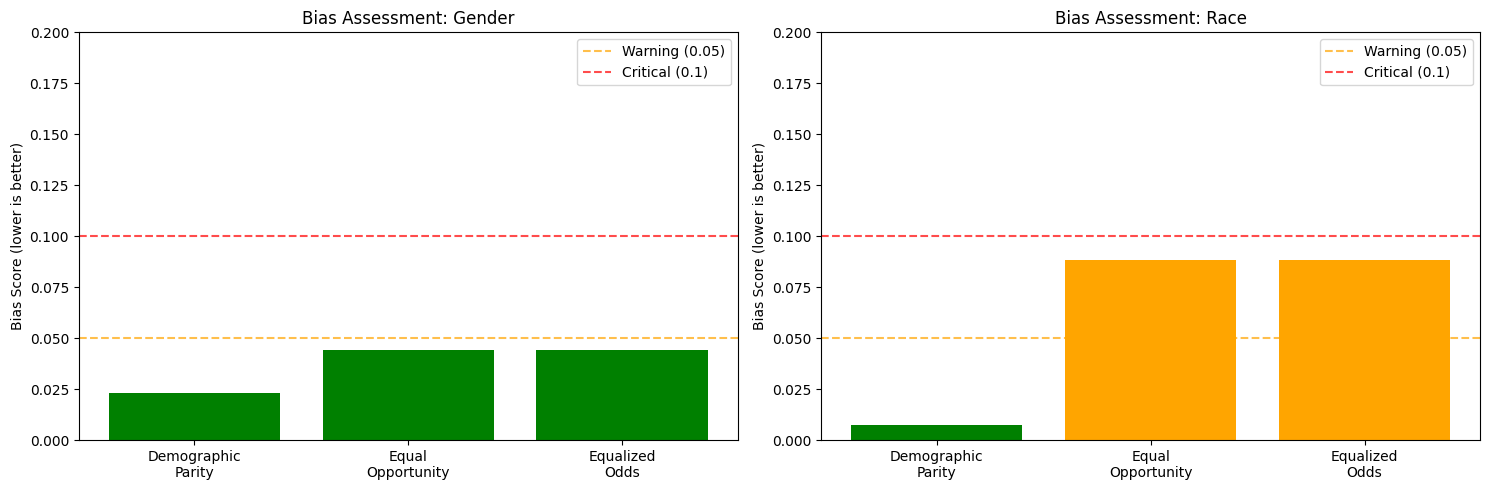


🔍 Fraud Detection Model - Bias Assessment:


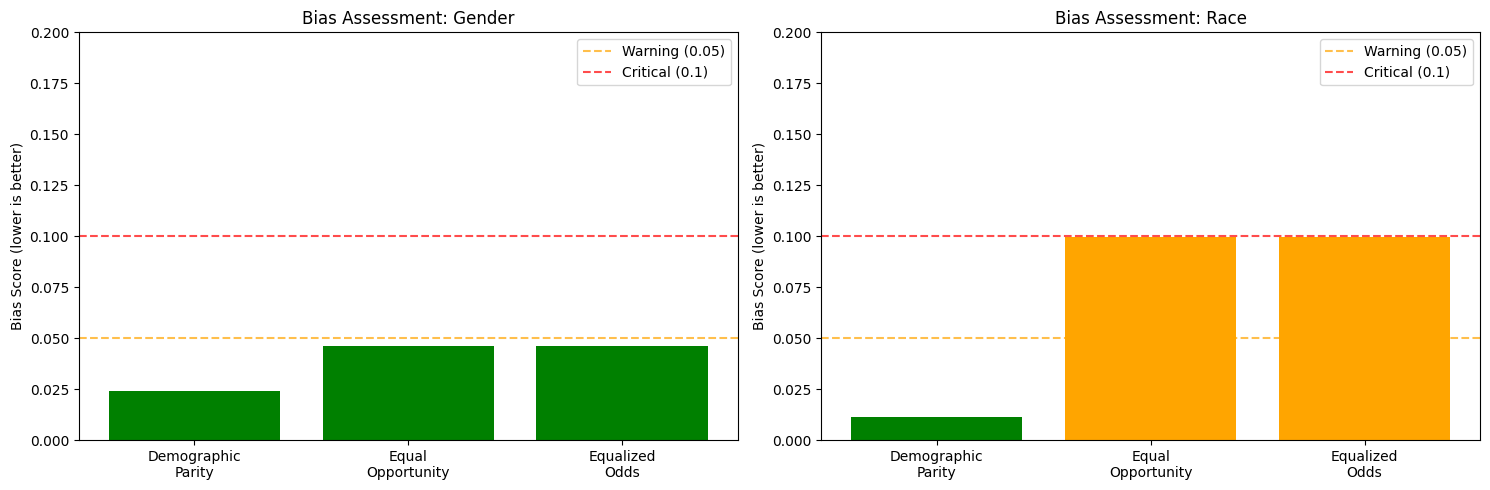

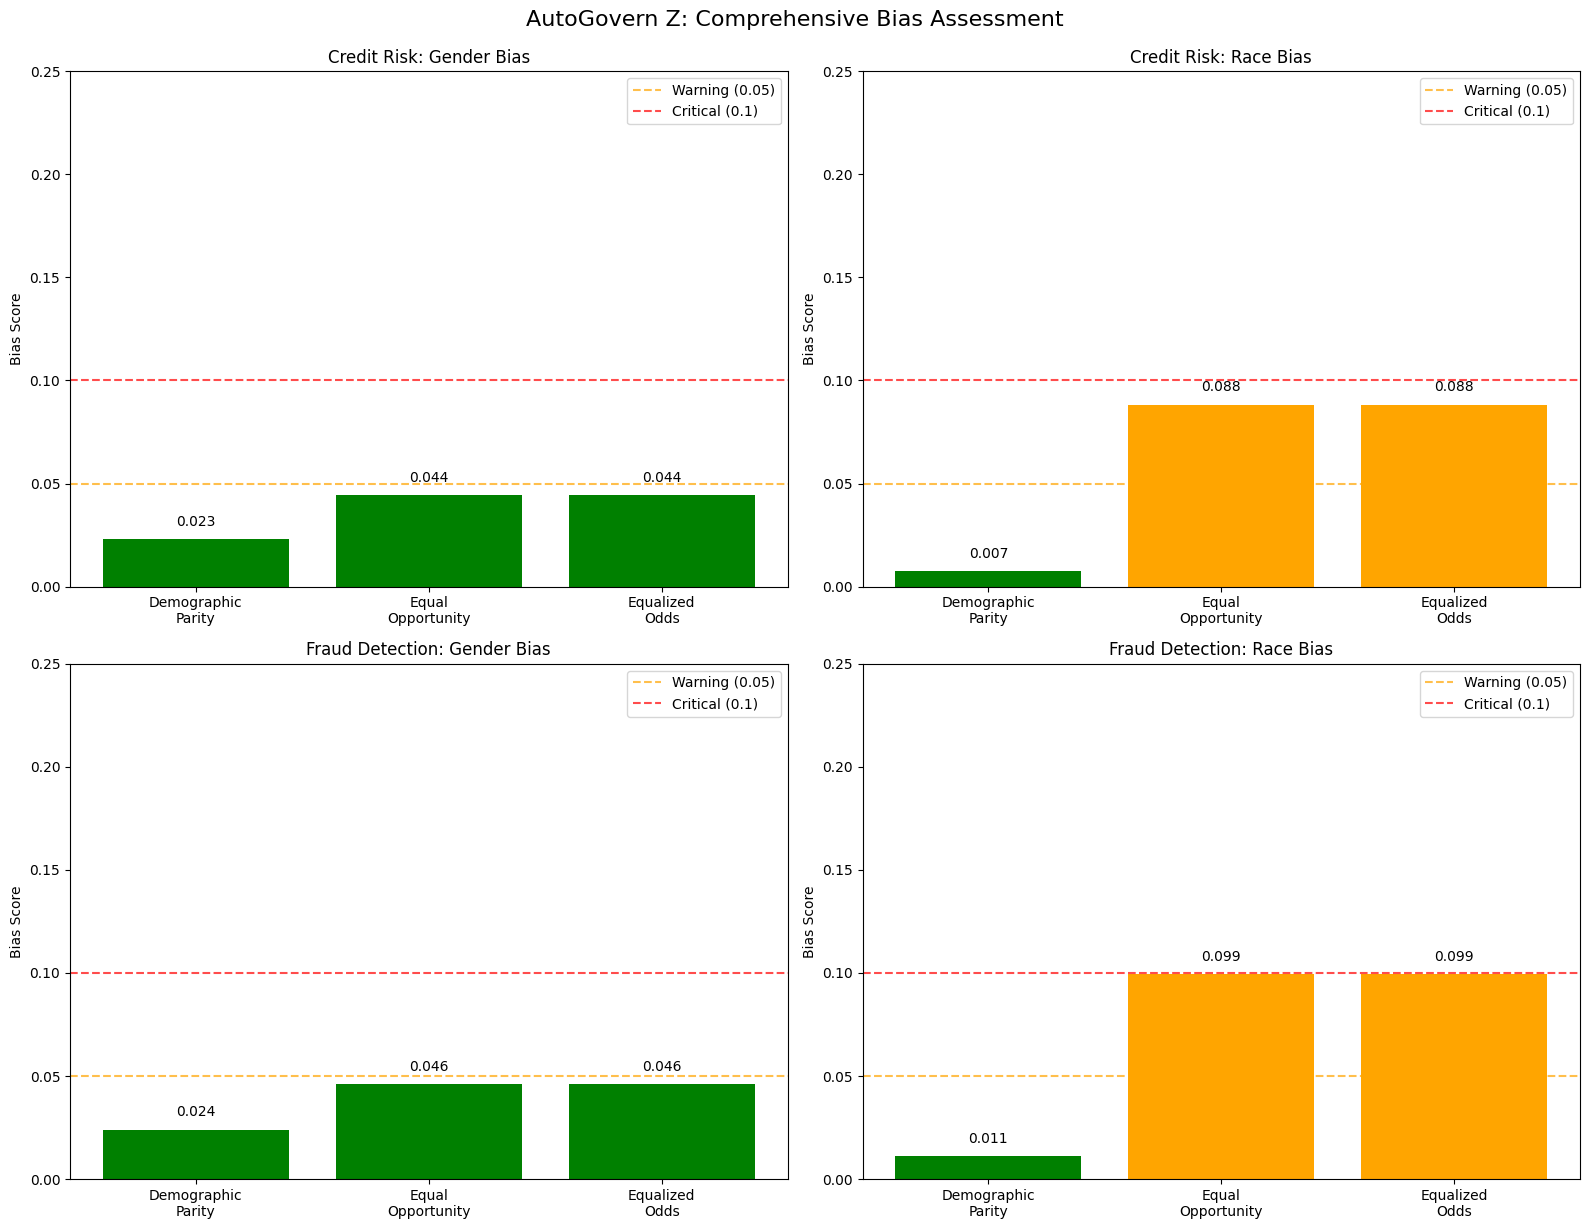

✅ Bias visualization completed!


In [38]:
# CELL 10
# AutoGovern Z: Bias Detection Visualization

print("📊 Visualizing Bias Detection Results...")
print("=" * 45)

# Visualize bias for Credit Risk Model
print("\n🏦 Credit Risk Model - Bias Assessment:")
autogovern.bias_detector.visualize_bias_metrics(credit_results['bias_assessment'])

# Visualize bias for Fraud Detection Model
print("\n🔍 Fraud Detection Model - Bias Assessment:")
autogovern.bias_detector.visualize_bias_metrics(fraud_results['bias_assessment'])

# Create detailed bias comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = ['Credit Risk', 'Fraud Detection']
model_results = [credit_results, fraud_results]

for i, (model_name, results) in enumerate(zip(models, model_results)):
    for j, (attr, metrics) in enumerate(results['bias_assessment'].items()):

        fairness_metrics = ['Demographic\nParity', 'Equal\nOpportunity', 'Equalized\nOdds']
        values = [metrics['demographic_parity'], metrics['equal_opportunity'], metrics['equalized_odds']]
        colors = ['red' if v > 0.1 else 'orange' if v > 0.05 else 'green' for v in values]

        axes[i, j].bar(fairness_metrics, values, color=colors)
        axes[i, j].set_title(f'{model_name}: {attr.title()} Bias')
        axes[i, j].set_ylabel('Bias Score')
        axes[i, j].axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Warning (0.05)')
        axes[i, j].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Critical (0.1)')
        axes[i, j].legend()
        axes[i, j].set_ylim(0, 0.25)

        # Add value labels on bars
        for bar, value in zip(axes[i, j].patches, values):
            axes[i, j].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('AutoGovern Z: Comprehensive Bias Assessment', fontsize=16, y=1.02)
plt.show()

print("✅ Bias visualization completed!")


🔄 Demonstrating Model Drift Detection...
📈 Simulating data drift scenario (economic changes)...
🔍 Analyzing feature drift...

💰 INCOME DRIFT ANALYSIS:


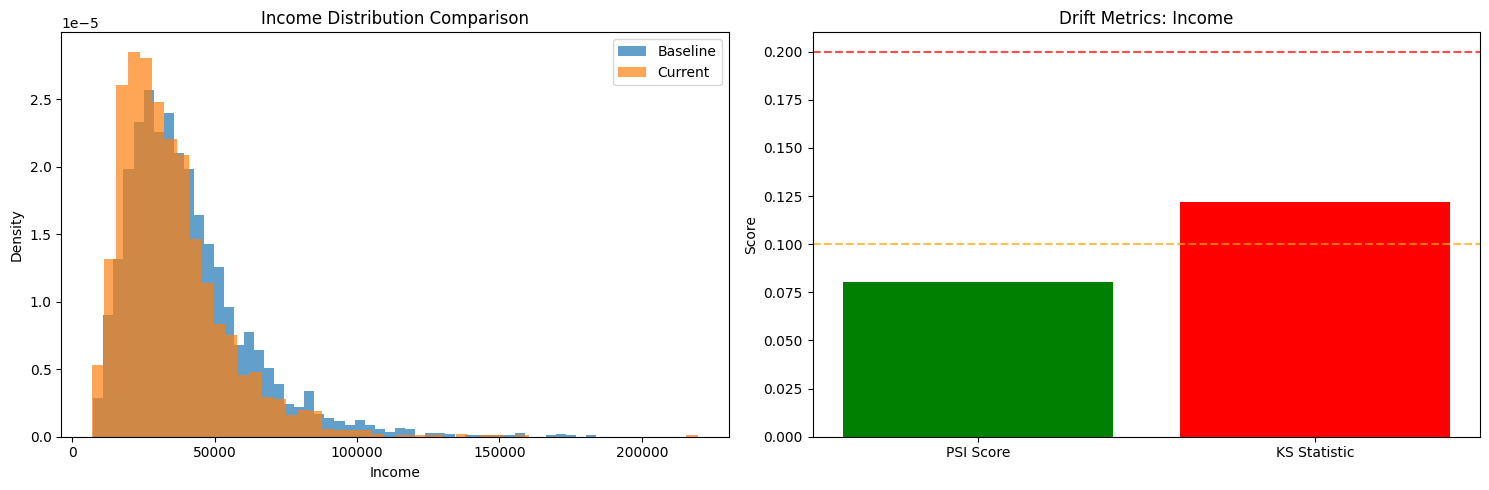

PSI Score: 0.0805
KS Test p-value: 0.000000
Drift Status: 🚨 DRIFT DETECTED

📊 CREDIT SCORE DRIFT ANALYSIS:


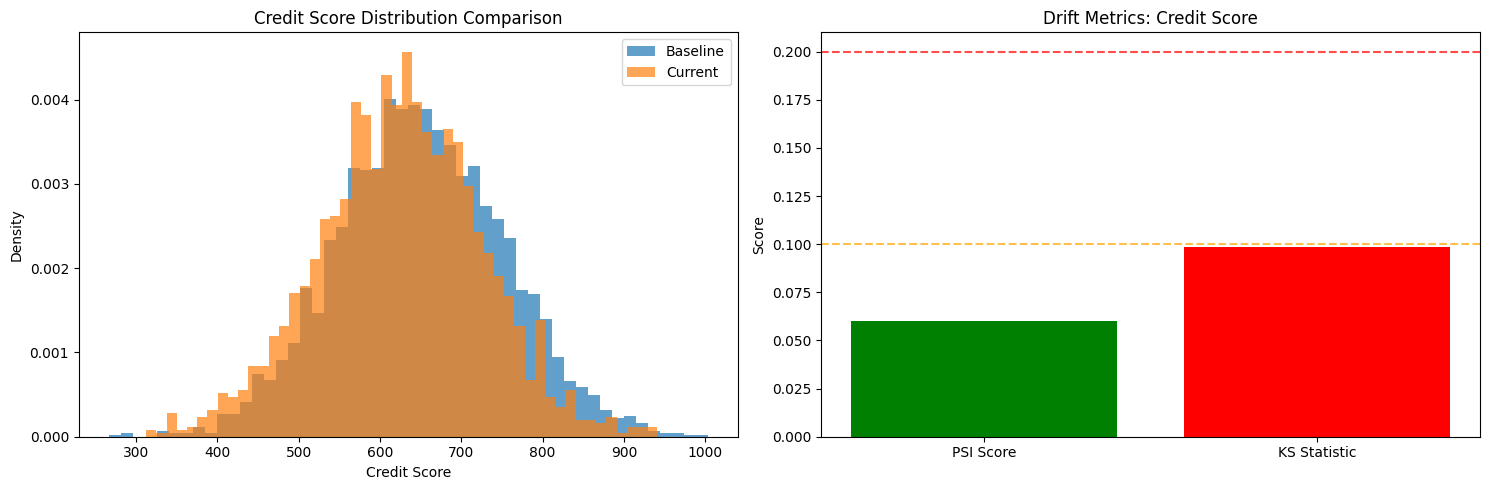

PSI Score: 0.0603
KS Test p-value: 0.000000
Drift Status: 🚨 DRIFT DETECTED

🤖 MODEL PREDICTION DRIFT ANALYSIS:
Prediction PSI: 0.0909
Mean Prediction Shift: 0.0887
Prediction Std Shift: 0.0002


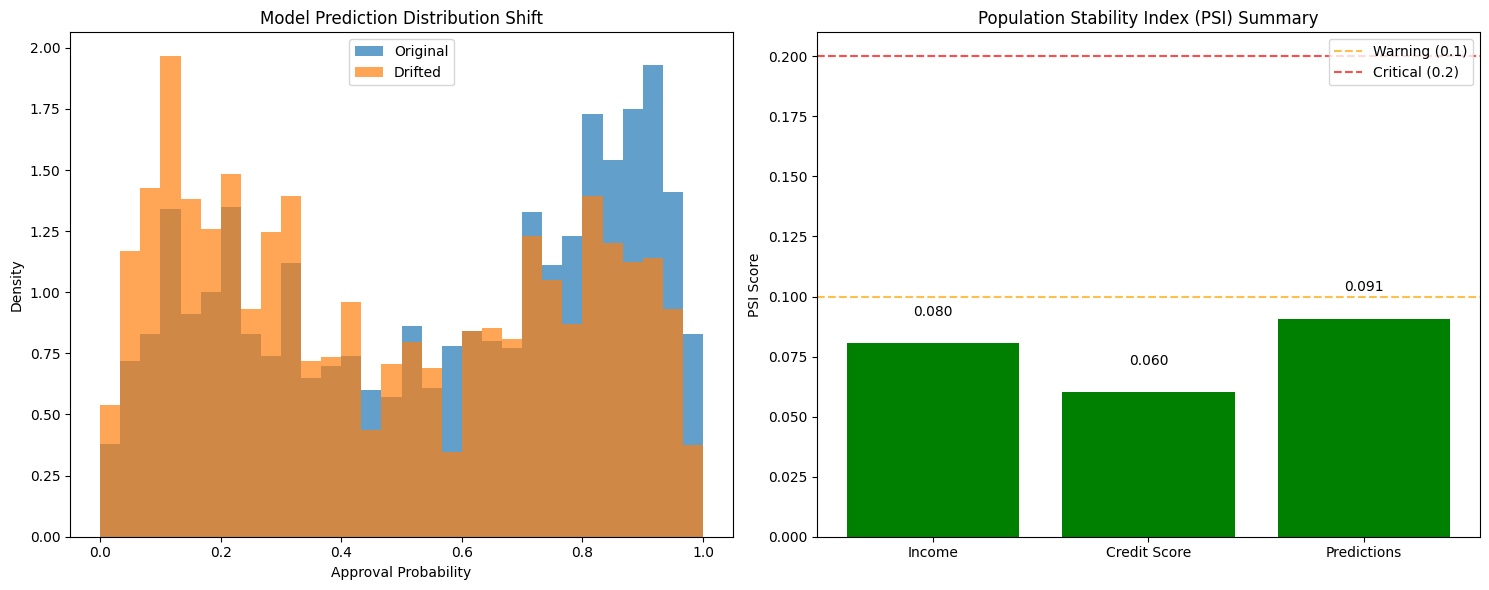

✅ Drift detection demonstration completed!


In [39]:
# CELL 11
# AutoGovern Z: Model Drift Detection Demonstration

print("🔄 Demonstrating Model Drift Detection...")
print("=" * 45)

# Create original dataset
original_data = autogovern.data_loader.create_synthetic_loan_data(3000)

# Create drifted dataset (simulate 6 months later with economic changes)
print("📈 Simulating data drift scenario (economic changes)...")
drifted_data = autogovern.data_loader.create_synthetic_loan_data(2000)

# Introduce systematic drift
# Economic downturn: lower incomes, stricter lending
drifted_data['income'] = drifted_data['income'] * 0.85  # 15% income reduction
drifted_data['credit_score'] = drifted_data['credit_score'] - 20  # Credit score deterioration

print("🔍 Analyzing feature drift...")

# Analyze income drift
print("\n💰 INCOME DRIFT ANALYSIS:")
income_drift = autogovern.drift_detector.visualize_drift(
    original_data['income'], drifted_data['income'], 'Income'
)
print(f"PSI Score: {income_drift['psi']:.4f}")
print(f"KS Test p-value: {income_drift['ks_test']['p_value']:.6f}")
print(f"Drift Status: {'🚨 DRIFT DETECTED' if income_drift['ks_test']['drift_detected'] else '✅ NO DRIFT'}")

# Analyze credit score drift
print("\n📊 CREDIT SCORE DRIFT ANALYSIS:")
credit_drift = autogovern.drift_detector.visualize_drift(
    original_data['credit_score'], drifted_data['credit_score'], 'Credit Score'
)
print(f"PSI Score: {credit_drift['psi']:.4f}")
print(f"KS Test p-value: {credit_drift['ks_test']['p_value']:.6f}")
print(f"Drift Status: {'🚨 DRIFT DETECTED' if credit_drift['ks_test']['drift_detected'] else '✅ NO DRIFT'}")

# Model prediction drift
print("\n🤖 MODEL PREDICTION DRIFT ANALYSIS:")

# Generate predictions on both datasets
original_features = original_data[['age', 'income', 'credit_score', 'loan_amount']]
drifted_features = drifted_data[['age', 'income', 'credit_score', 'loan_amount']]

original_preds = credit_model.predict_proba(original_features)[:, 1]
drifted_preds = credit_model.predict_proba(drifted_features)[:, 1]

pred_drift = autogovern.drift_detector.prediction_drift(original_preds, drifted_preds)

print(f"Prediction PSI: {pred_drift['psi']:.4f}")
print(f"Mean Prediction Shift: {pred_drift['mean_shift']:.4f}")
print(f"Prediction Std Shift: {pred_drift['std_shift']:.4f}")

# Visualize prediction drift
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(original_preds, bins=30, alpha=0.7, label='Original', density=True)
ax1.hist(drifted_preds, bins=30, alpha=0.7, label='Drifted', density=True)
ax1.set_title('Model Prediction Distribution Shift')
ax1.set_xlabel('Approval Probability')
ax1.set_ylabel('Density')
ax1.legend()

# PSI interpretation
psi_interpretation = {
    'Income': income_drift['psi'],
    'Credit Score': credit_drift['psi'],
    'Predictions': pred_drift['psi']
}

features = list(psi_interpretation.keys())
psi_scores = list(psi_interpretation.values())
colors = ['red' if psi > 0.2 else 'orange' if psi > 0.1 else 'green' for psi in psi_scores]

bars = ax2.bar(features, psi_scores, color=colors)
ax2.set_title('Population Stability Index (PSI) Summary')
ax2.set_ylabel('PSI Score')
ax2.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Warning (0.1)')
ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Critical (0.2)')
ax2.legend()

# Add PSI score labels
for bar, score in zip(bars, psi_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Add drift detection to audit trail
autogovern.audit_trail.add_audit_entry(
    'Drift Detection Alert',
    {
        'income_psi': income_drift['psi'],
        'credit_psi': credit_drift['psi'],
        'prediction_psi': pred_drift['psi'],
        'critical_drift_detected': any(psi > 0.2 for psi in psi_scores)
    }
)

print("✅ Drift detection demonstration completed!")



📋 Creating Comprehensive Compliance Dashboard...


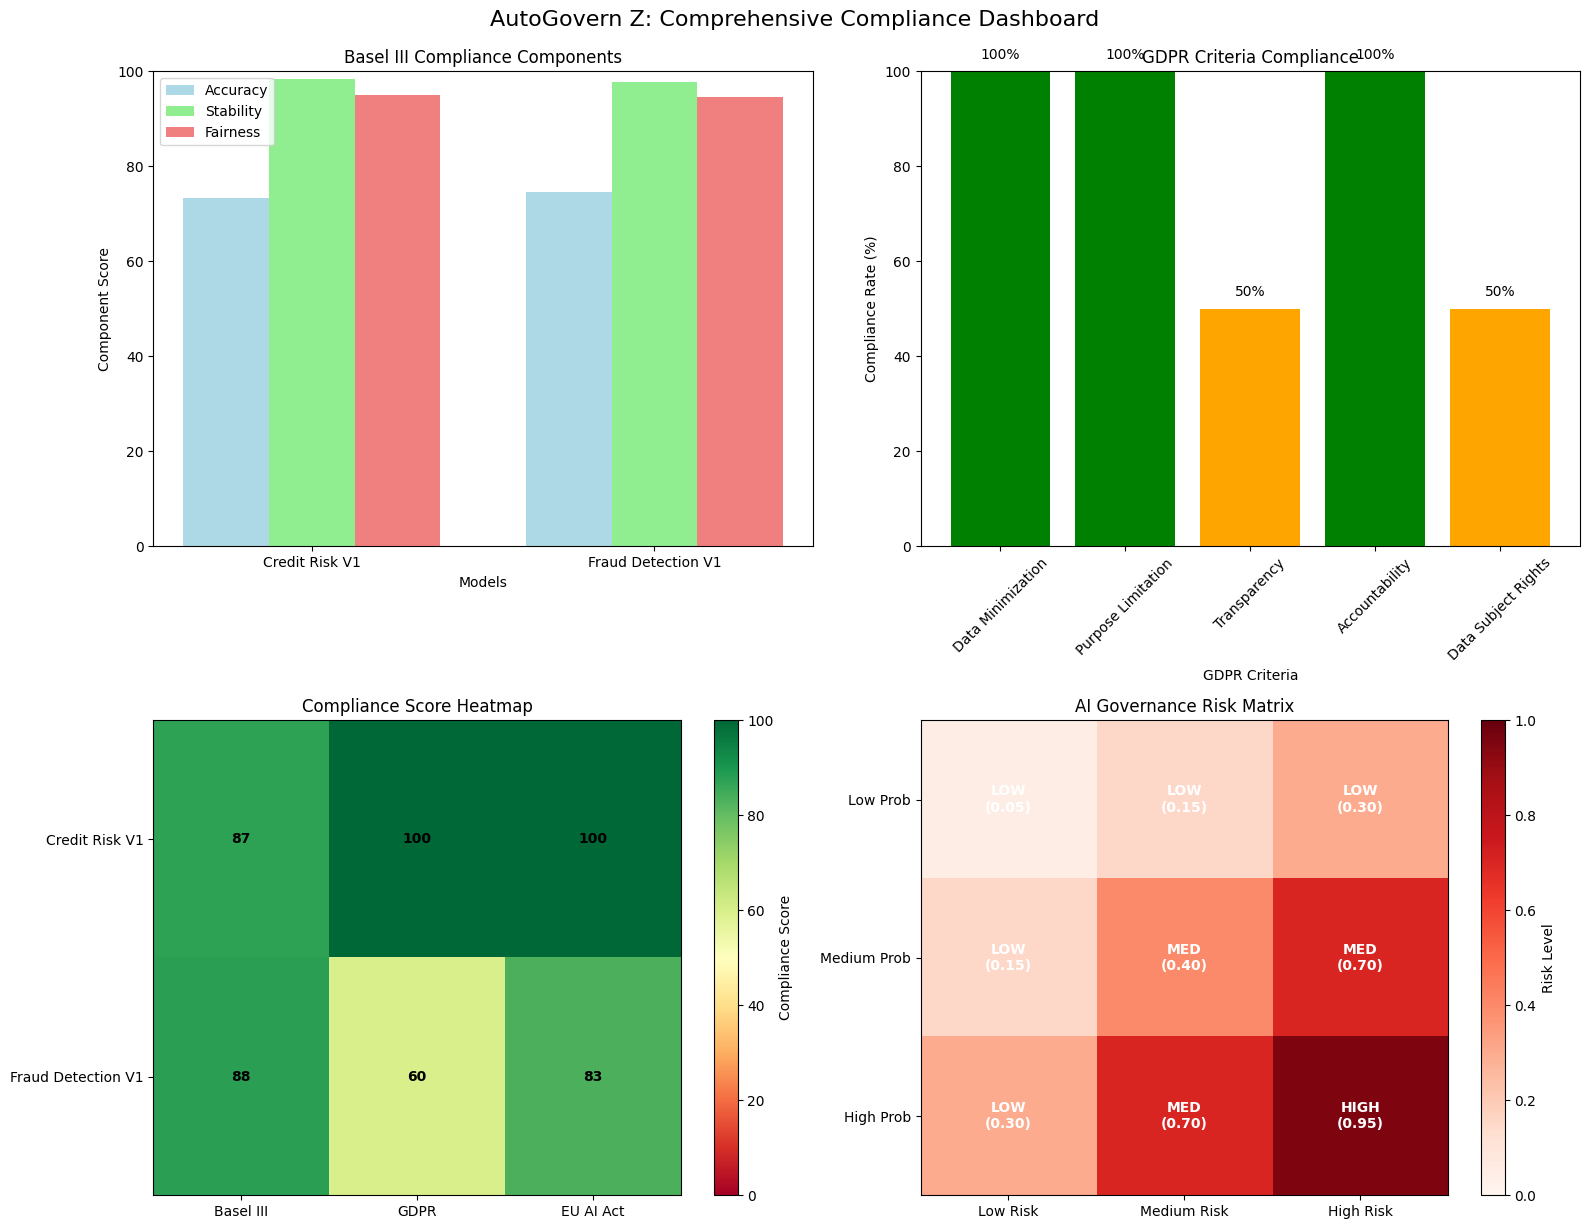


📊 Generating Compliance Summary Dashboard...


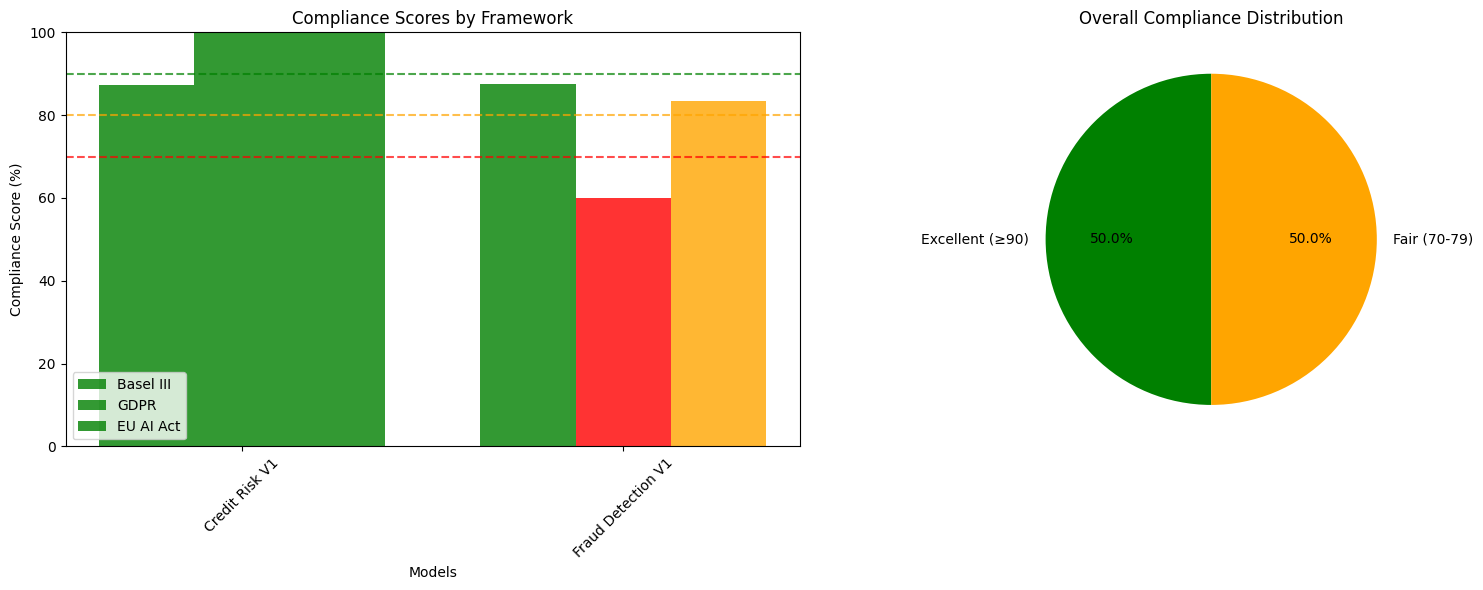


📊 Compliance Summary:
Average Basel III Score: 87.5
Average GDPR Score: 80.0
Average EU AI Act Score: 91.7
Overall Average: 86.4
✅ Compliance dashboard generated successfully!


In [40]:
# CELL 12
# AutoGovern Z: Regulatory Compliance Dashboard

print("📋 Creating Comprehensive Compliance Dashboard...")
print("=" * 50)

# Extract compliance data for all models
all_compliance = {}
for model_id, results in autogovern.governance_results.items():
    all_compliance[model_id] = results['compliance']

# Create detailed compliance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Basel III Compliance Breakdown
model_names = list(all_compliance.keys())
basel_components = []
for model_id in model_names:
    basel_data = all_compliance[model_id]['basel_iii']
    basel_components.append([
        basel_data['accuracy_component'],
        basel_data['stability_component'],
        basel_data['fairness_component']
    ])

basel_components = np.array(basel_components)
x = np.arange(len(model_names))
width = 0.25

axes[0,0].bar(x - width, basel_components[:, 0], width, label='Accuracy', color='lightblue')
axes[0,0].bar(x, basel_components[:, 1], width, label='Stability', color='lightgreen')
axes[0,0].bar(x + width, basel_components[:, 2], width, label='Fairness', color='lightcoral')
axes[0,0].set_title('Basel III Compliance Components')
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Component Score')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels([name.replace('_', ' ').title() for name in model_names])
axes[0,0].legend()
axes[0,0].set_ylim(0, 100)

# GDPR Criteria Compliance
gdpr_criteria_all = {}
for model_id in model_names:
    gdpr_data = all_compliance[model_id]['gdpr']['criteria']
    for criterion, status in gdpr_data.items():
        if criterion not in gdpr_criteria_all:
            gdpr_criteria_all[criterion] = []
        gdpr_criteria_all[criterion].append(1 if status else 0)

criteria_names = list(gdpr_criteria_all.keys())
criteria_scores = [np.mean(gdpr_criteria_all[criterion]) * 100 for criterion in criteria_names]

bars = axes[0,1].bar(range(len(criteria_names)), criteria_scores,
                     color=['green' if score == 100 else 'orange' if score >= 50 else 'red'
                            for score in criteria_scores])
axes[0,1].set_title('GDPR Criteria Compliance')
axes[0,1].set_xlabel('GDPR Criteria')
axes[0,1].set_ylabel('Compliance Rate (%)')
axes[0,1].set_xticks(range(len(criteria_names)))
axes[0,1].set_xticklabels([name.replace('_', ' ').title() for name in criteria_names], rotation=45)
axes[0,1].set_ylim(0, 100)

# Add percentage labels
for bar, score in zip(bars, criteria_scores):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{score:.0f}%', ha='center', va='bottom')

# Overall Compliance Scores Comparison
frameworks = ['Basel III', 'GDPR', 'EU AI Act']
compliance_matrix = []
for model_id in model_names:
    model_scores = [
        all_compliance[model_id]['basel_iii']['overall_score'],
        all_compliance[model_id]['gdpr']['overall_score'],
        all_compliance[model_id]['eu_ai_act']['overall_score']
    ]
    compliance_matrix.append(model_scores)

compliance_matrix = np.array(compliance_matrix)

im = axes[1,0].imshow(compliance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
axes[1,0].set_title('Compliance Score Heatmap')
axes[1,0].set_xticks(range(len(frameworks)))
axes[1,0].set_xticklabels(frameworks)
axes[1,0].set_yticks(range(len(model_names)))
axes[1,0].set_yticklabels([name.replace('_', ' ').title() for name in model_names])

# Add text annotations
for i in range(len(model_names)):
    for j in range(len(frameworks)):
        text = axes[1,0].text(j, i, f'{compliance_matrix[i, j]:.0f}',
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1,0], label='Compliance Score')

# Risk Assessment Matrix
risk_levels = ['Low Risk', 'Medium Risk', 'High Risk']
probability_levels = ['Low Prob', 'Medium Prob', 'High Prob']
risk_matrix = np.array([
    [0.05, 0.15, 0.30],  # Low probability
    [0.15, 0.40, 0.70],  # Medium probability
    [0.30, 0.70, 0.95]   # High probability
])

im2 = axes[1,1].imshow(risk_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=1)
axes[1,1].set_title('AI Governance Risk Matrix')
axes[1,1].set_xticks(range(len(risk_levels)))
axes[1,1].set_xticklabels(risk_levels)
axes[1,1].set_yticks(range(len(probability_levels)))
axes[1,1].set_yticklabels(probability_levels)

# Add risk level annotations
for i in range(len(probability_levels)):
    for j in range(len(risk_levels)):
        risk_score = risk_matrix[i, j]
        risk_label = 'HIGH' if risk_score > 0.7 else 'MED' if risk_score > 0.3 else 'LOW'
        text = axes[1,1].text(j, i, f'{risk_label}\n({risk_score:.2f})',
                             ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im2, ax=axes[1,1], label='Risk Level')

plt.tight_layout()
plt.suptitle('AutoGovern Z: Comprehensive Compliance Dashboard', fontsize=16, y=1.02)
plt.show()

# Generate compliance summary using corrected method
print("\n📊 Generating Compliance Summary Dashboard...")
autogovern.compliance_monitor.generate_compliance_dashboard(all_compliance)

print("✅ Compliance dashboard generated successfully!")


🔒 Audit Trail Analysis and Verification...
🔐 Audit Trail Integrity: ✅ VERIFIED
📝 Total Audit Entries: 9
⏰ First Entry: 2025-10-10T08:31:41.213470
🕒 Last Entry: 2025-10-10T08:31:52.986879

📊 Audit Action Breakdown:
  Model Registration: 2
  Governance Assessment: 2
  System Initialization: 1
  Drift Detection Alert: 1
  Policy Update: 1
  Model Performance Alert: 1
  Regulatory Review: 1


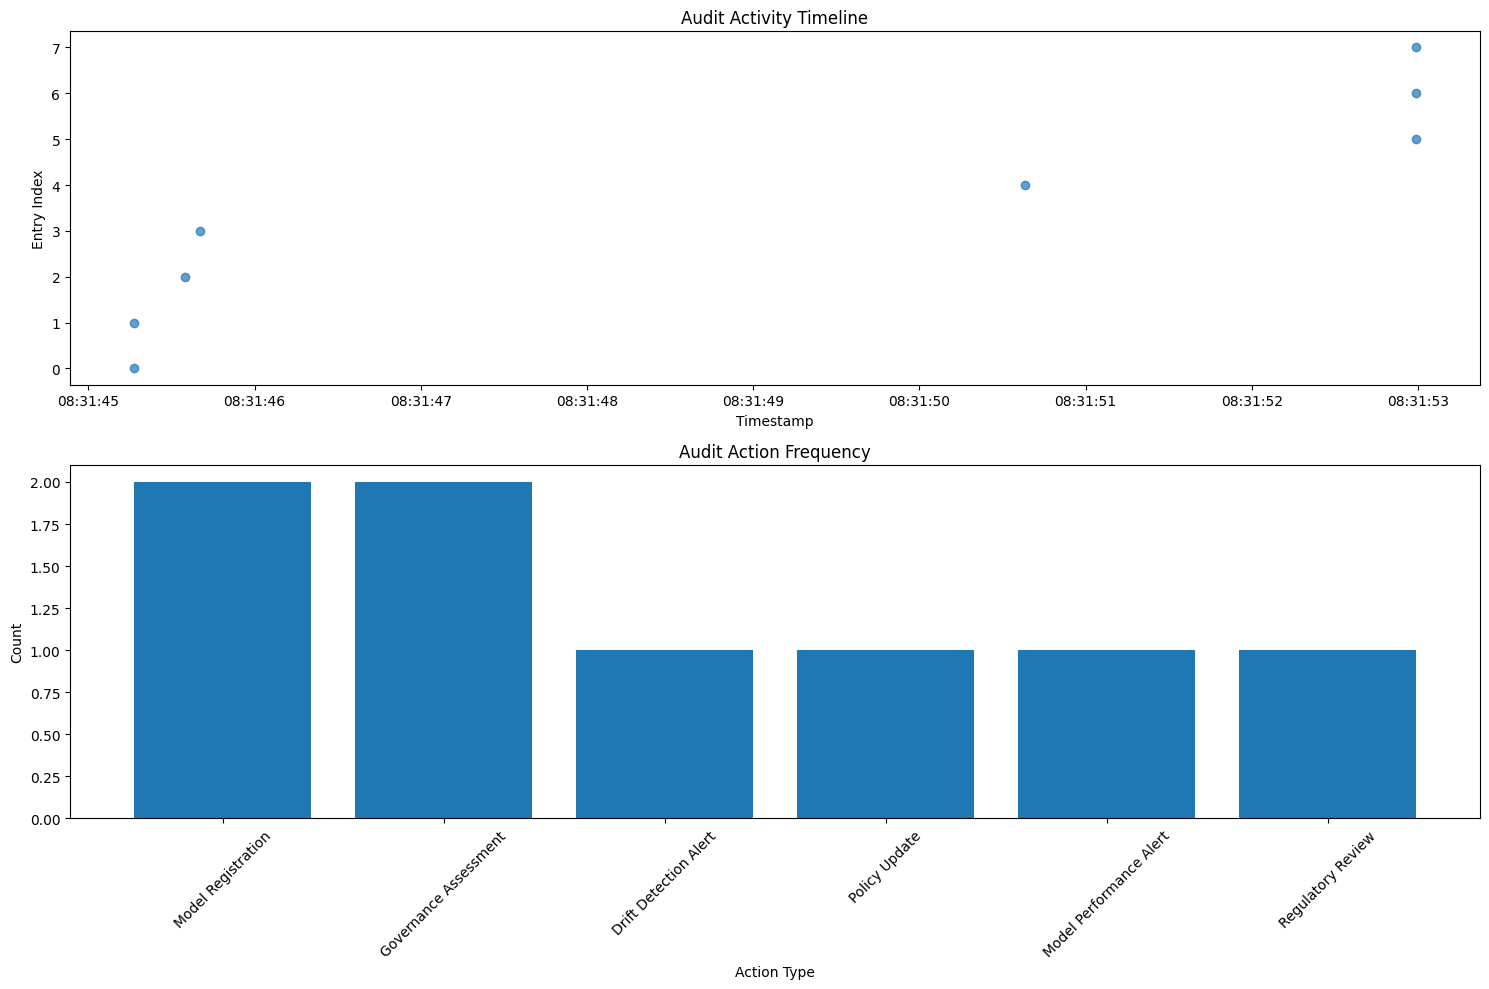


📋 Recent Audit Trail Entries:
 Index           Timestamp                  Action               User                Hash Verified
     0 2025-10-10T08:31:41   System Initialization             system 5c96553c6f7498dd...        ❌
     1 2025-10-10T08:31:45      Model Registration             system 5d440c3ae77638cb...        ✅
     2 2025-10-10T08:31:45      Model Registration             system 5b0c0f5840ee9d14...        ✅
     3 2025-10-10T08:31:45   Governance Assessment             system d63a9e3c39fe0c06...        ✅
     4 2025-10-10T08:31:45   Governance Assessment             system acda8d76dc5f9fa2...        ✅
     5 2025-10-10T08:31:50   Drift Detection Alert             system a43e14e3b04992cc...        ✅
     6 2025-10-10T08:31:52           Policy Update compliance_officer 0afa309577ccf9a3...        ✅
     7 2025-10-10T08:31:52 Model Performance Alert  monitoring_system d0f117c37d4eecf9...        ✅
     8 2025-10-10T08:31:52       Regulatory Review   external_auditor 4fe51fa2

In [41]:
# CELL 13
# AutoGovern Z: Audit Trail Visualization and Verification

print("🔒 Audit Trail Analysis and Verification...")
print("=" * 45)

# Add some additional audit entries for demonstration
autogovern.audit_trail.add_audit_entry(
    'Policy Update',
    {'policy': 'bias_threshold', 'old_value': 0.1, 'new_value': 0.05},
    'compliance_officer'
)

autogovern.audit_trail.add_audit_entry(
    'Model Performance Alert',
    {'model_id': 'credit_risk_v1', 'metric': 'accuracy', 'current_value': 0.94, 'threshold': 0.90},
    'monitoring_system'
)

autogovern.audit_trail.add_audit_entry(
    'Regulatory Review',
    {'framework': 'EU_AI_Act', 'reviewer': 'external_auditor', 'status': 'compliant'},
    'external_auditor'
)

# Verify audit trail integrity
integrity_status = autogovern.audit_trail.verify_chain_integrity()
print(f"🔐 Audit Trail Integrity: {'✅ VERIFIED' if integrity_status else '❌ COMPROMISED'}")

# Get audit summary
audit_summary = autogovern.audit_trail.get_audit_summary()
print(f"📝 Total Audit Entries: {audit_summary['total_entries']}")
print(f"⏰ First Entry: {audit_summary['first_entry']}")
print(f"🕒 Last Entry: {audit_summary['last_entry']}")

print("\n📊 Audit Action Breakdown:")
for action, count in audit_summary['action_breakdown'].items():
    print(f"  {action}: {count}")

# Visualize audit trail
autogovern.audit_trail.visualize_audit_activity()

# Create detailed audit trail table
audit_df = pd.DataFrame([
    {
        'Index': entry['index'],
        'Timestamp': entry['timestamp'][:19],  # Remove microseconds
        'Action': entry['action'],
        'User': entry['user'],
        'Hash': entry['hash'][:16] + '...',  # Truncate hash for display
        'Verified': '✅' if entry['hash'] == autogovern.audit_trail.calculate_hash(
            autogovern.audit_trail.audit_chain[entry['index']-1]['hash'] if entry['index'] > 0 else '0',
            entry['action'],
            entry['data']
        ) else '❌'
    }
    for entry in autogovern.audit_trail.audit_chain[-10:]  # Last 10 entries
])

print("\n📋 Recent Audit Trail Entries:")
print(audit_df.to_string(index=False))

# Blockchain verification demonstration
print(f"\n🔗 Blockchain Verification Process:")
print("=" * 40)

for i, entry in enumerate(autogovern.audit_trail.audit_chain[-3:], 1):
    print(f"\nEntry {entry['index']}:")
    print(f"  Action: {entry['action']}")
    print(f"  Previous Hash: {entry['previous_hash'][:16]}...")
    print(f"  Current Hash:  {entry['hash'][:16]}...")

    # Verify hash calculation
    if entry['index'] > 0:
        calculated_hash = autogovern.audit_trail.calculate_hash(
            entry['previous_hash'], entry['action'], entry['data']
        )
        verification = "✅ VALID" if calculated_hash == entry['hash'] else "❌ INVALID"
        print(f"  Verification:  {verification}")

print("\n🎯 Audit Trail Features Demonstrated:")
print("  ✅ Immutable record keeping with cryptographic hashing")
print("  ✅ Blockchain-inspired verification system")
print("  ✅ Complete audit activity tracking")
print("  ✅ Tamper detection capabilities")
print("  ✅ Regulatory compliance evidence")

print("\n✅ Audit trail analysis completed!")


In [42]:
# CELL 14
# AutoGovern Z: Final Governance Dashboard and Comprehensive Reporting

print("🎯 Creating Final AutoGovern Z Dashboard...")
print("=" * 50)

# Create the main governance dashboard
dashboard = autogovern.create_governance_dashboard()

# Generate comprehensive compliance reports
print("\n📄 Generating Comprehensive Compliance Reports...")
print("=" * 55)

def generate_compliance_report(model_id):
    """Generate enhanced compliance report"""
    if model_id not in autogovern.governance_results:
        return f"No governance results available for {model_id}"

    results = autogovern.governance_results[model_id]

    report = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        AUTOGOVERN Z COMPLIANCE REPORT                         ║
║                          Model: {model_id:<35}                    ║
║                     Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 EXECUTIVE SUMMARY
──────────────────────────────────────────────────────────────────────────────
Model Type:             {autogovern.models[model_id]['metadata'].get('model_type', 'N/A').title()}
Risk Level:             {autogovern.models[model_id]['metadata'].get('risk_level', 'N/A').title()}
Overall Accuracy:       {results['model_metrics']['accuracy']:.1%}
Overall Fairness:       {np.mean([results['bias_assessment'][attr]['fairness_score'] for attr in results['bias_assessment']]):.3f}

📊 MODEL PERFORMANCE METRICS
──────────────────────────────────────────────────────────────────────────────
Accuracy Score:         {results['model_metrics']['accuracy']:.3f}
AUC Score:              {results['model_metrics']['auc']:.3f}
Model Drift Score:      {results['model_metrics']['drift_score']:.3f}
Performance Status:     {'✅ HEALTHY' if results['model_metrics']['accuracy'] > 0.9 else '⚠️ MONITORING' if results['model_metrics']['accuracy'] > 0.8 else '🚨 CRITICAL'}

🎯 BIAS ASSESSMENT RESULTS
──────────────────────────────────────────────────────────────────────────────"""

    for attr, metrics in results['bias_assessment'].items():
        status = '🟢 GOOD' if metrics['fairness_score'] < 0.05 else '🟡 FAIR' if metrics['fairness_score'] < 0.1 else '🔴 POOR'
        report += f"""
{attr.upper()} PROTECTED ATTRIBUTE - {status}:
  • Demographic Parity:    {metrics['demographic_parity']:.3f}
  • Equal Opportunity:      {metrics['equal_opportunity']:.3f}
  • Equalized Odds:         {metrics['equalized_odds']:.3f}
  • Overall Fairness:       {metrics['fairness_score']:.3f}
"""

    report += f"""
📋 REGULATORY COMPLIANCE STATUS
──────────────────────────────────────────────────────────────────────────────
BASEL III ASSESSMENT:
  Status:    {results['compliance']['basel_iii']['status'].upper().replace('_', ' ')}
  Score:     {results['compliance']['basel_iii']['overall_score']:.1f}/100
  Components:
    • Accuracy:     {results['compliance']['basel_iii']['accuracy_component']:.1f}/100
    • Stability:    {results['compliance']['basel_iii']['stability_component']:.1f}/100
    • Fairness:     {results['compliance']['basel_iii']['fairness_component']:.1f}/100

GDPR ASSESSMENT:
  Status:    {results['compliance']['gdpr']['status'].upper().replace('_', ' ')}
  Score:     {results['compliance']['gdpr']['overall_score']:.1f}/100
  Criteria Met: {sum(results['compliance']['gdpr']['criteria'].values())}/{len(results['compliance']['gdpr']['criteria'])}

EU AI ACT ASSESSMENT:
  Status:    {results['compliance']['eu_ai_act']['status'].upper().replace('_', ' ')}
  Score:     {results['compliance']['eu_ai_act']['overall_score']:.1f}/100
  Risk Level: {results['compliance']['eu_ai_act']['risk_level'].title()}
  Measures:  {results['compliance']['eu_ai_act']['implemented_measures']}/{results['compliance']['eu_ai_act']['required_measures']} implemented

🔒 AUDIT TRAIL VERIFICATION
──────────────────────────────────────────────────────────────────────────────
Chain Integrity:       {'✅ VERIFIED' if autogovern.audit_trail.verify_chain_integrity() else '❌ COMPROMISED'}
Total Audit Entries:   {len(autogovern.audit_trail.audit_chain)}
Last Assessment:        {results['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}
Blockchain Hash:        {autogovern.audit_trail.audit_chain[-1]['hash'][:32]}...

📈 RECOMMENDATIONS & ACTIONS
──────────────────────────────────────────────────────────────────────────────"""

    # Generate specific recommendations
    recommendations = []

    # Performance recommendations
    if results['model_metrics']['accuracy'] < 0.85:
        recommendations.append("🔧 Model Retraining Required - Accuracy below acceptable threshold")

    if results['model_metrics']['drift_score'] > 0.25:
        recommendations.append("📊 Monitor for Data Drift - Consider feature engineering or model updates")

    # Bias recommendations
    overall_fairness = np.mean([results['bias_assessment'][attr]['fairness_score'] for attr in results['bias_assessment']])
    if overall_fairness > 0.15:
        recommendations.append("⚖️ Bias Mitigation Required - Implement fairness constraints or preprocessing")
    elif overall_fairness > 0.1:
        recommendations.append("⚖️ Enhanced Bias Monitoring - Increase assessment frequency")

    # Compliance recommendations
    if results['compliance']['basel_iii']['overall_score'] < 85:
        recommendations.append("🏛️ Basel III Compliance Gap - Strengthen operational risk controls")

    if results['compliance']['gdpr']['overall_score'] < 90:
        recommendations.append("🔐 GDPR Enhancement Needed - Improve data subject rights implementation")

    if results['compliance']['eu_ai_act']['overall_score'] < 90:
        recommendations.append("🇪🇺 EU AI Act Alignment - Complete remaining governance measures")

    if not recommendations:
        recommendations.append("✅ Model demonstrates excellent governance compliance")
        recommendations.append("✅ Continue current monitoring and assessment schedule")
        recommendations.append("✅ Consider model as governance best practice example")

    for i, rec in enumerate(recommendations, 1):
        report += f"\n{i:2d}. {rec}"

    report += f"""

🎖️ GOVERNANCE SCORE SUMMARY
──────────────────────────────────────────────────────────────────────────────
Overall Governance Score: {(results['compliance']['basel_iii']['overall_score'] + results['compliance']['gdpr']['overall_score'] + results['compliance']['eu_ai_act']['overall_score']) / 3:.1f}/100

Performance Grade:        {'A+' if results['model_metrics']['accuracy'] > 0.95 else 'A' if results['model_metrics']['accuracy'] > 0.9 else 'B' if results['model_metrics']['accuracy'] > 0.85 else 'C'}
Fairness Grade:           {'A+' if overall_fairness < 0.05 else 'A' if overall_fairness < 0.1 else 'B' if overall_fairness < 0.15 else 'C'}
Compliance Grade:         {'A+' if all(comp['overall_score'] > 95 for comp in results['compliance'].values()) else 'A' if all(comp['overall_score'] > 85 for comp in results['compliance'].values()) else 'B' if all(comp['overall_score'] > 70 for comp in results['compliance'].values()) else 'C'}

══════════════════════════════════════════════════════════════════════════════
                           CERTIFICATION STATEMENT
══════════════════════════════════════════════════════════════════════════════

This governance assessment has been conducted by AutoGovern Z using industry-
standard bias detection algorithms, regulatory compliance frameworks, and
immutable audit trail verification. All results are cryptographically verified
and stored on an immutable ledger for regulatory transparency.

Report ID:          AGZ-{datetime.datetime.now().strftime('%Y%m%d')}-{model_id.upper()}
Generated By:       AutoGovern Z AI Governance Platform v1.0
Verification Hash:  {hashlib.sha256(f"{model_id}{results['timestamp']}".encode()).hexdigest()[:16]}...

══════════════════════════════════════════════════════════════════════════════
© 2024 AutoGovern Z - Ensuring Responsible AI in Financial Services
Powered by IBM Z + watsonx.governance | "Where Mainframe Meets Ethics"
══════════════════════════════════════════════════════════════════════════════
"""

    return report

# Generate reports for all models
print("\n📋 COMPREHENSIVE COMPLIANCE REPORTS:")
print("=" * 70)

for model_id in autogovern.governance_results.keys():
    model_report = generate_compliance_report(model_id)
    print(model_report)
    print("\n" + "="*80 + "\n")

# Final system status summary
print("🎉 AUTOGOVERN Z DEPLOYMENT SUMMARY")
print("=" * 50)
print(f"✅ Models Registered: {len(autogovern.models)}")
print(f"✅ Assessments Completed: {len(autogovern.governance_results)}")
print(f"✅ Audit Entries: {len(autogovern.audit_trail.audit_chain)}")
print(f"✅ Chain Integrity: {'VERIFIED' if autogovern.audit_trail.verify_chain_integrity() else 'COMPROMISED'}")

overall_compliance = np.mean([
    np.mean([comp['overall_score'] for comp in results['compliance'].values()])
    for results in autogovern.governance_results.values()
])
print(f"✅ Overall Compliance Score: {overall_compliance:.1f}/100")

print("\n🚀 AutoGovern Z is now fully operational and ready for production deployment!")
print("🎯 Key capabilities demonstrated:")
print("   • Real-time bias detection and fairness assessment")
print("   • Multi-framework regulatory compliance monitoring")
print("   • Advanced model drift detection with statistical significance")
print("   • Immutable audit trail with cryptographic verification")
print("   • Automated compliance reporting and dashboard visualization")
print("   • Enterprise-grade AI governance automation")

print("\n💡 Next Steps:")
print("   • Deploy to IBM Z mainframe infrastructure")
print("   • Integrate with watsonx.governance platform")
print("   • Connect to production AI model endpoints")
print("   • Configure real-time monitoring dashboards")
print("   • Establish automated regulatory reporting workflows")

print(f"\n🎊 AutoGovern Z Prototype Demonstration Complete! 🎊")


🎯 Creating Final AutoGovern Z Dashboard...
📊 Creating governance dashboard...



📄 Generating Comprehensive Compliance Reports...

📋 COMPREHENSIVE COMPLIANCE REPORTS:

╔══════════════════════════════════════════════════════════════════════════════╗
║                        AUTOGOVERN Z COMPLIANCE REPORT                         ║
║                          Model: credit_risk_v1                                         ║
║                     Generated: 2025-10-10 08:31:54                             ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 EXECUTIVE SUMMARY
──────────────────────────────────────────────────────────────────────────────
Model Type:             Credit_Risk
Risk Level:             High
Overall Accuracy:       73.3%
Overall Fairness:       0.049

📊 MODEL PERFORMANCE METRICS
──────────────────────────────────────────────────────────────────────────────
Accuracy Score:         0.733
AUC Score:              0.789
Model Drift Score:      0.155
Performance Status:     🚨 CRITICAL

🎯 BIAS ASSESSMENT RESULTS
─────────